<a href="https://colab.research.google.com/github/NkM20/IA/blob/main/C%C3%B3pia_de_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Recognition of handwritten digits using a CNN

Notebook Cell 1: Install dependencies if needed (skip if you know they’re already installed)
Note: PyTorch and torchvision are pre-installed on Google Colab, but if you're using this locally, uncomment this cell.

In [53]:
# !pip install torch torchvision

Notebook Cell 2: Import necessary libraries

In [54]:

import torch
import torch.nn as nn
import torch.optim as optim
import time
from torchvision import datasets as dsets, transforms
from torch.utils.data import DataLoader
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [55]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),  # Random zoom
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Define transformations for test data (no augmentation, just normalization)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the images
])

train_dataset = dsets.MNIST(root='./data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor(),
                           download=True)



 Notebook Cell 4: Make dataset iterable

In [56]:

batch_size = 100
n_iters = 9000
num_epochs = int(n_iters / (len(train_dataset) / batch_size))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)



Notebook Cell 5: Define the CNN model using nn.Sequential

In [57]:
class OptimizedCNNModel(nn.Module):
    def __init__(self):
        super(OptimizedCNNModel, self).__init__()

        self.model = nn.Sequential(
            # First Convolutional Block with 3x3 convolutions and BatchNorm
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Output: 14x14x32

            # Second Convolutional Block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Output: 7x7x64

            # Third Convolutional Block with Spatial Dropout
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Output: 3x3x128
            nn.Dropout2d(0.3),  # Dropout to prevent overfitting

            # Global Average Pooling
            nn.AdaptiveAvgPool2d((1, 1)),  # Output: 1x1x128

            # Flatten and Fully Connected Block
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.5),  # Dropout in fully connected layer
            nn.Linear(64, 10)  # Output layer for 10 classes
        )

    def forward(self, x):
        return self.model(x)

 Notebook Cell 6: Define the loss function and optimizer

In [58]:

model = OptimizedCNNModel().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss applies softmax and then the -ln() function

# Learning rate and optimizer
learning_rate = 0.0001  # Lower learning rate for Adam
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


Notebook Cell 7: Train the model and test it

**Notebook** Cell 3: Load the MNIST dataset
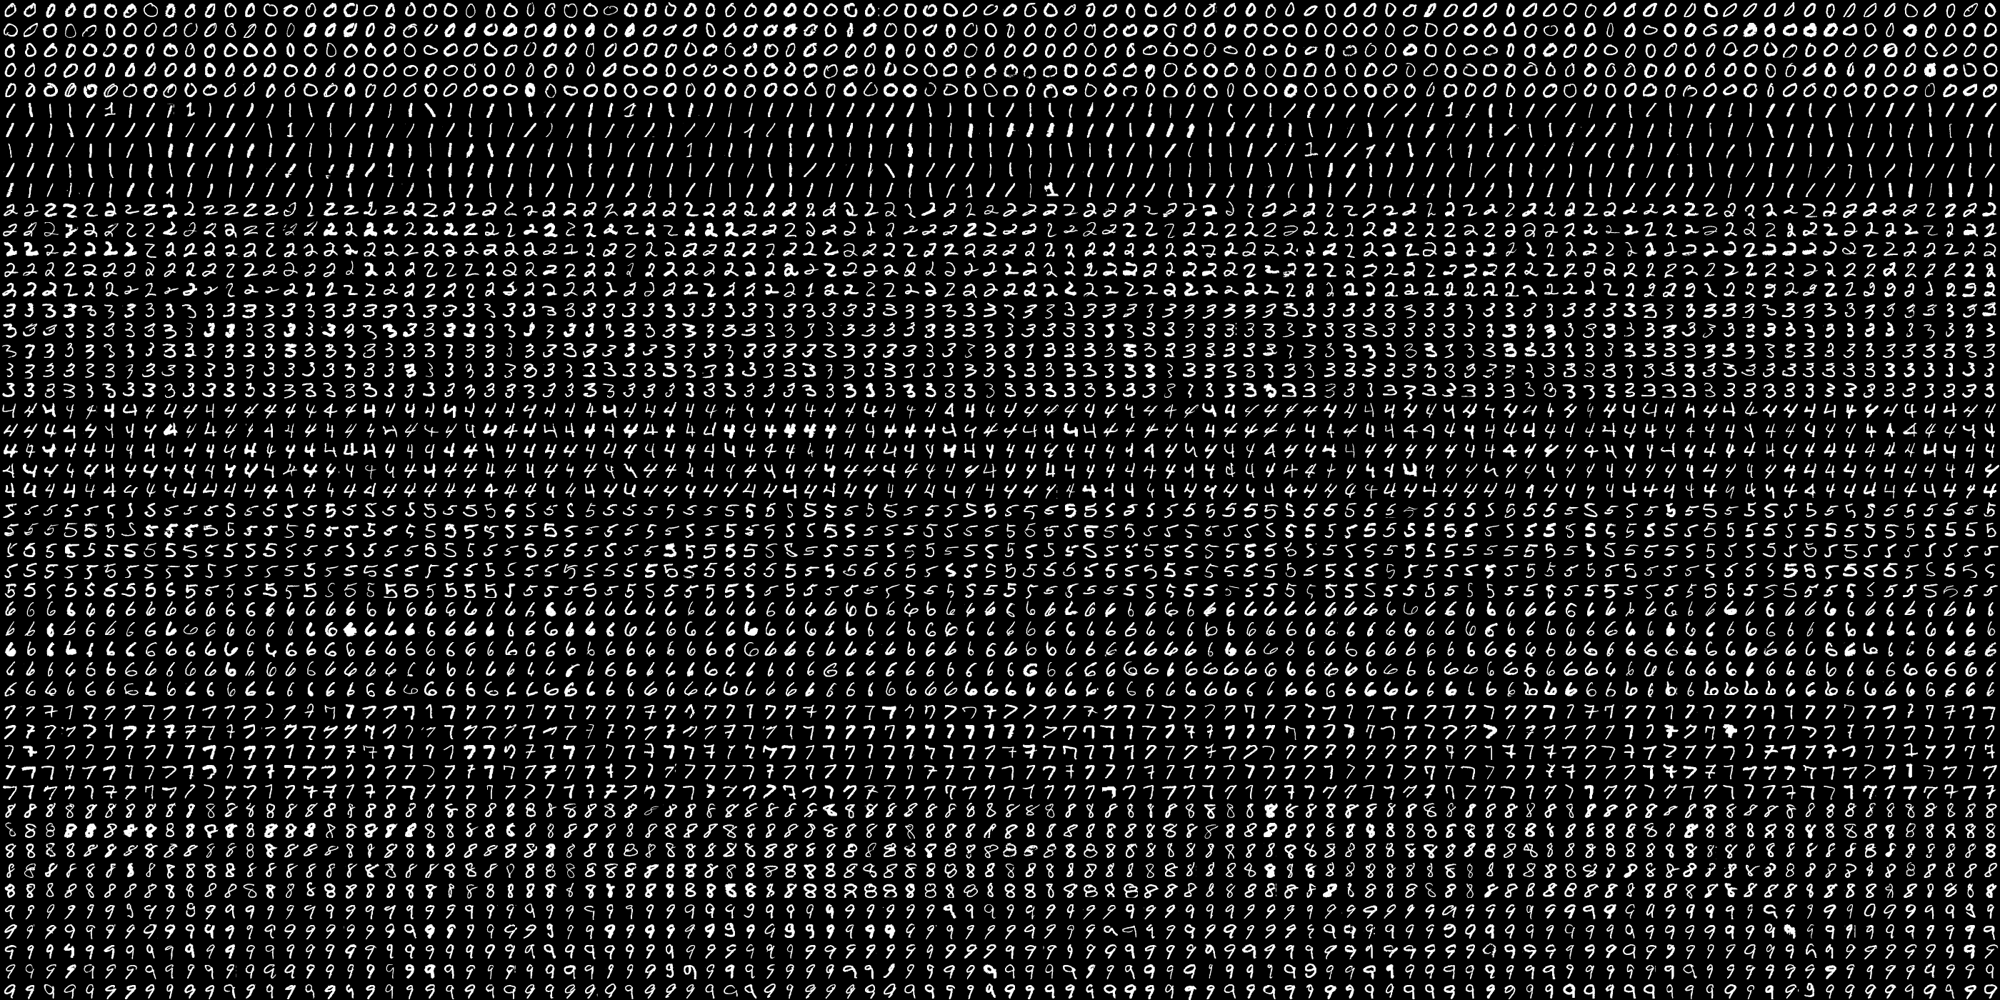


In [59]:
# Training and Evaluation Loop
iter = 0
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    model.train()
    for images, labels in train_loader:
        start = time.time()

        # Move data to device
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        iter += 1
        end = time.time()

        if iter % 500 == 0:  # Evaluate every 500 iterations
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)

                    # Forward pass
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)

                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            accuracy = 100.0 * correct / total
            print(f"Iteration: {iter}. Loss: {loss.item():.4f}. Accuracy: {accuracy:.2f}%")
            print("Batch time (s):", end-start)

    # Step the learning rate scheduler **after the epoch**
    scheduler.step()

    print(f"End of Epoch {epoch+1}")

Epoch 1/15
Iteration: 500. Loss: 0.2547. Accuracy: 97.93%
Batch time (s): 0.004317522048950195
End of Epoch 1
Epoch 2/15
Iteration: 1000. Loss: 0.1410. Accuracy: 98.51%
Batch time (s): 0.0048258304595947266
End of Epoch 2
Epoch 3/15
Iteration: 1500. Loss: 0.1184. Accuracy: 98.85%
Batch time (s): 0.0045893192291259766
End of Epoch 3
Epoch 4/15
Iteration: 2000. Loss: 0.1048. Accuracy: 98.99%
Batch time (s): 0.005404472351074219
End of Epoch 4
Epoch 5/15
Iteration: 2500. Loss: 0.0576. Accuracy: 99.04%
Batch time (s): 0.004584312438964844
Iteration: 3000. Loss: 0.0218. Accuracy: 99.13%
Batch time (s): 0.003949880599975586
End of Epoch 5
Epoch 6/15
Iteration: 3500. Loss: 0.0385. Accuracy: 99.31%
Batch time (s): 0.004494190216064453
End of Epoch 6
Epoch 7/15
Iteration: 4000. Loss: 0.0833. Accuracy: 99.22%
Batch time (s): 0.004822731018066406
End of Epoch 7
Epoch 8/15
Iteration: 4500. Loss: 0.0589. Accuracy: 99.49%
Batch time (s): 0.004279375076293945
End of Epoch 8
Epoch 9/15
Iteration: 5000